# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [59]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [60]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
uniques = set().union(y_test, y_train)
n_classes = len(uniques)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

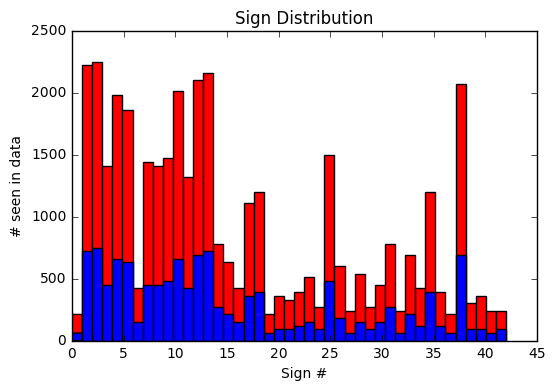

In [61]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.xlabel('Sign #')
plt.ylabel('# seen in data')
plt.hist(y_train,43, facecolor="red")


plt.xlabel('Sign #')
plt.ylabel('# seen in data')
plt.title('Sign Distribution')
plt.hist(y_test,43, facecolor="blue")

plt.show()

#shows the number of occurences of each sign in the dataset


Image Label: 25
Image Label: 38
Image Label: 1
Image Label: 17
Image Label: 8
Image Label: 18
Image Label: 2
Image Label: 25
Image Label: 4
Image Label: 1


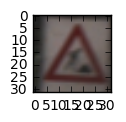

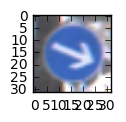

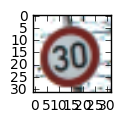

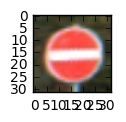

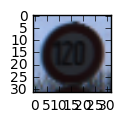

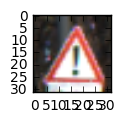

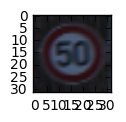

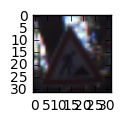

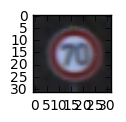

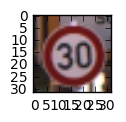

In [62]:
import random


for i in range(0,10):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()

    print("Image Label: {}".format(y_train[index]))
    plt.figure(figsize=(1,1))
    plt.imshow(image)





----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [48]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def preprocess(images):
    count = len(images)
    for i in range(0, count):
        for x in range(0,32):
            for y in range(0,32):
                r = images[i][x][y][0]
                g = images[i][x][y][1]
                b = images[i][x][y][2]
                avg = (r+g+b)/3
                images[i][x][y][0] = images[i][x][y][1] = images[i][x][y][2] = avg
    for i in range(0,10):
        index = random.randint(0, len(images))
        image = images[index].squeeze()
        print("Image Label: {}".format(y_train[index]))
        plt.figure(figsize=(1,1))
        plt.imshow(image)   
    


Image Label: 5
Image Label: 4
Image Label: 38
Image Label: 15
Image Label: 35
Image Label: 8
Image Label: 9
Image Label: 28
Image Label: 17
Image Label: 16


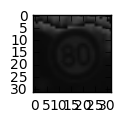

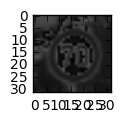

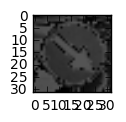

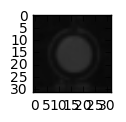

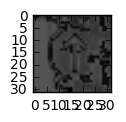

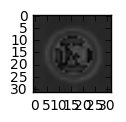

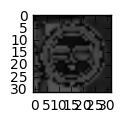

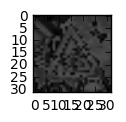

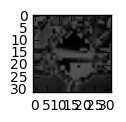

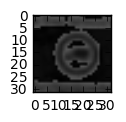

In [49]:
#X_train_preprocessed = preprocess(X_train)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_
I gray scaled the images to provide some consistency between the lighting of sign images. This also reduced the images dimensions to 32x32x1. Ultimately I decided not to inlcude the preprocessing as my validation accuracy actually took a hit. 
Note: I realize that I could've Grayscaled images much easier with OpenCV, but i was unable to install it on my AWS instance. (I'm new to the Python environment)


**Answer:**

In [63]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Training and test data come from the German Traffic Sign data set. I did not create additional data, though I recognize that this could be useful. Slightly rotating images and other minor distortions could have lead to better accuracay of my model. The more data the better. 
Validation data is generated with the sklearn.model_selection module, which, in my case, splits off 20% of the training data for use as a validation set. 

In [64]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
   
    # SOLUTION: Pooling. Input = 30x30x6. Output = 15x15x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 12x12x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

   
    
    # SOLUTION: Pooling. Input = 12x12x16. Output = 6x6x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 6x6x16. Output = 576.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 576. Output = 225.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 225), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(225))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
                          
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 225. Output = 110.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(225, 110), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(110))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 110. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(110, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [65]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [66]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [67]:


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
My final architecture is based on Yann LeCun's LeNet-5 architecture. There a some slight changes:
I played around with the filter size and thus the dimensions of each layer and tried to find something that gave the best results against the validation set.
I also added Dropout to the first two fully connected layers
5 total layers
    - 1: Convolutional Layer
        - Relu Activation
        - Max Pooling
    - 2: Convolutional Layer
        - Relu Activation
        - Max Pooling
        - Flatten output shape to 1D
    - 3: Fully Connected
        - Relu Activation
        - Dropout (75% keep probability)
    - 4: Fully Connected
        - Relu Activation
        - Dropout (75% keep probability)
    - 5: Fully Connected
        - 43 Ouputs, 1 for each traffic sign
        
    

In [68]:
### Train your model here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .75})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.507

EPOCH 2 ...
Validation Accuracy = 0.756

EPOCH 3 ...
Validation Accuracy = 0.826

EPOCH 4 ...
Validation Accuracy = 0.906

EPOCH 5 ...
Validation Accuracy = 0.921

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.952

EPOCH 8 ...
Validation Accuracy = 0.956

EPOCH 9 ...
Validation Accuracy = 0.965

EPOCH 10 ...
Validation Accuracy = 0.966

EPOCH 11 ...
Validation Accuracy = 0.966

EPOCH 12 ...
Validation Accuracy = 0.969

EPOCH 13 ...
Validation Accuracy = 0.963

EPOCH 14 ...
Validation Accuracy = 0.973

EPOCH 15 ...
Validation Accuracy = 0.976

EPOCH 16 ...
Validation Accuracy = 0.978

EPOCH 17 ...
Validation Accuracy = 0.978

EPOCH 18 ...
Validation Accuracy = 0.975

EPOCH 19 ...
Validation Accuracy = 0.979

EPOCH 20 ...
Validation Accuracy = 0.983

EPOCH 21 ...
Validation Accuracy = 0.978

EPOCH 22 ...
Validation Accuracy = 0.978

EPOCH 23 ...
Validation Accuracy = 0.979

EPOCH 24 ...
Validation Accura

In [69]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.920


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I trained my model with 25 Epochs, a batch size of 128, AdamOptimizer, a learning rate of 0.001.

Every batch of every epoch was run through a training operation that consisted of:
    - Softmax / cross entropy on logits
    - reduced mean on cross entropy
    - loss minimization using the Adam optimizer and a learning rate of .001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
My solution is based off of Yann LeCun's LeNet-5 architecture. This is a well-known deep learning architecture, and one of the first Convolutional Neural Nets used for image recognition. That makes it a good fit for this project. 
I experimented with many different tweaks to this architecture by trial and error to see what yielded high validation accuracy. I first started tweaking the filter size of the colnvolutional layers. I discovered that a filter size of 3x3 tended to yield better results than the default 5x5 filter. Because of the larger filter, the size of the fully connected layers were larger. I applied dropout to the fully connected layers and also saw improvement in validation accuracy. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

5 New Test Images


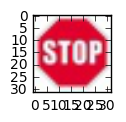

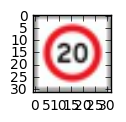

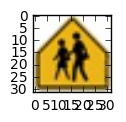

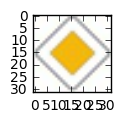

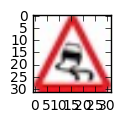

In [70]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#import matplotlib.image as mpimg
#import matplotlib.pyplot as plt
#img_stop = mpimg.imread('stop.jpg')
#plt.show(img)

from skimage import io

stop_img = io.imread('stop.jpg')
plt.figure(figsize=(1,1))
plt.imshow(stop_img)
kph_img = io.imread('20kmh.jpg')
plt.figure(figsize=(1,1))
plt.imshow(kph_img)
ped_img = io.imread('pedestrian.jpg')
plt.figure(figsize=(1,1))
plt.imshow(ped_img)
priority_img = io.imread('priority.jpg')
plt.figure(figsize=(1,1))
plt.imshow(priority_img)
slippery_img = io.imread('slippery.jpg')
plt.figure(figsize=(1,1))
plt.imshow(slippery_img)
print("5 New Test Images")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I got these images from the internet and they do not have any notable distortions or obstructions that would make classification difficult. The fact that they are "zoomed in" or larger than what you might expect from a picture of a sign taken from a few feet away, could be a notable difference from the images that the model trained on. 

In [71]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    stop_accuracy = evaluate([stop_img], [14])
    print("Stop Sign Accuracy = {:.3f}".format(stop_accuracy))
    
    ped_accuracy = evaluate([ped_img], [27])
    print("Pedestrian Sign Accuracy = {:.3f}".format(ped_accuracy))
    
    kph_accuracy = evaluate([kph_img], [0])
    print("Speed Limit 20 Sign Accuracy = {:.3f}".format(kph_accuracy))
    
    priority_accuracy = evaluate([priority_img], [12])
    print("Priority Road Sign Accuracy = {:.3f}".format(priority_accuracy))
    
    slippery_accuracy = evaluate([slippery_img], [23]) 
    print("Slippery Road Sign Accuracy = {:.3f}".format(slippery_accuracy))

Stop Sign Accuracy = 1.000
Pedestrian Sign Accuracy = 0.000
Speed Limit 20 Sign Accuracy = 0.000
Priority Road Sign Accuracy = 1.000
Slippery Road Sign Accuracy = 1.000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model's performance on the new test images was mediocre - 60%. It was close on the 20kph sign (though it was 120kph). And I think the pedestrian sign I provided is different that the pedestrian signs it has been trained on (American vs European signs). 

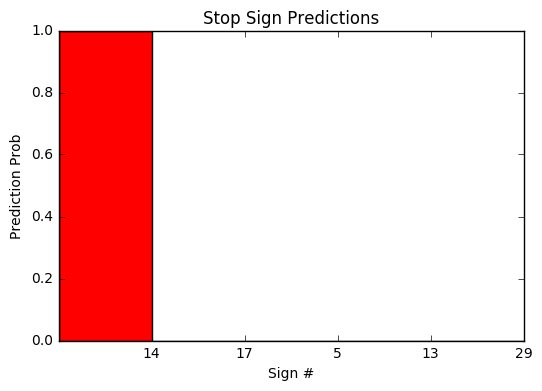

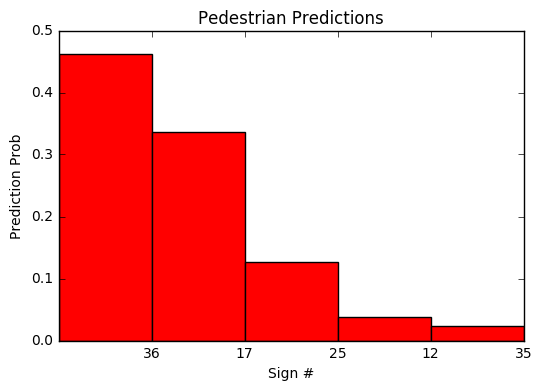

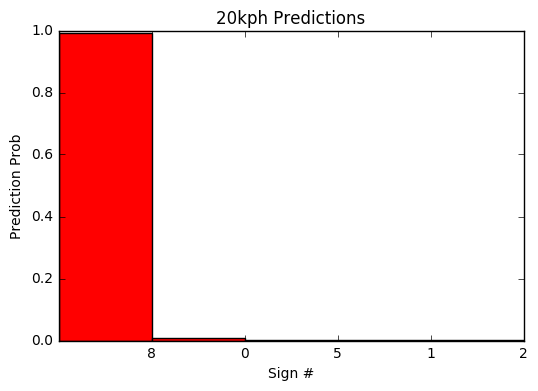

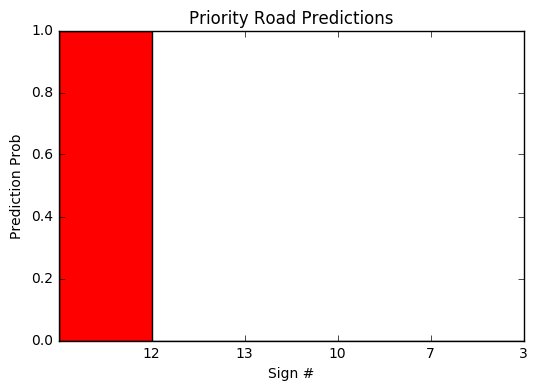

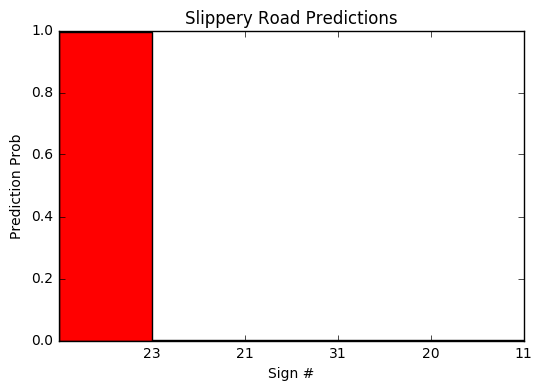

In [72]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    sftmax = tf.nn.softmax(logits)
    top_k_operation = tf.nn.top_k(sftmax, 5, sorted=True)
    
    image_names = ["Stop Sign", "Pedestrian", "20kph", "Priority Road", "Slippery Road"]
    images = [stop_img, ped_img, kph_img, priority_img, slippery_img]
    
    for i in range(0, 5):
        top_k_results = sess.run(top_k_operation, feed_dict={x: [images[i]], keep_prob: 1})
        top_k_values = top_k_results[0]
        top_k_indices = top_k_results[1]

        ind = np.arange(5) 
        width = 1       

        values = top_k_values[0]
        plt.bar(ind, values, width, color='r')
        plt.ylabel('Prediction Prob')
        plt.xlabel('Sign #')
        plt.title("%s Predictions" % image_names[i])
        plt.xticks(ind+width, tuple(top_k_indices[0]))

        plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The softmax probabilities show that my model was confident on one of the images that it got wrong! 
It was very confident about the 20kph speed limit sign being a 120 kph sign - close, but perhaps dangerously wrong! 20kph came in as second highest probability 
It was unable to identify the pedestrian in its top 5 probabilities. This may be due to the difference in pedestrian signs. I provided an "American" pdedestrian sign which is different

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.